<a href="https://colab.research.google.com/github/MarkoArsenovic/PPPO2021/blob/main/Vezbe05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Vežbe 05** Binarna obrada fotografije II

## Sadržaj

1. Uvod
2. Podudaranje morfološkog obrasca
3. Segmentacija: morfološki “sliv”
4. Detekcija objekata pomoću morfološkog sliva
5. Detekcija objekata pomoću *LOG scale-space*
6. Prebrojavanje objekata
7. Detekcija i razdvajanje različitih vrsta objekata



### Uvod

Binarne fotografije su fotografije čiji pikseli imaju samo dve moguće vrednosti intenziteta. Obično su prikazani kao crno-beli. Numerički, dve vrednosti su često 0 za crnu, a 1 ili 255 za belu.

Binarne fotografije se često proizvode graničnim vrednostima nijansi sive ili fotografije u boji kako bi se objekt na slici odvojio od pozadine. Boja predmeta (obično bela) naziva se bojom u prvom planu. Ostatak (obično crni) naziva se bojom pozadine.


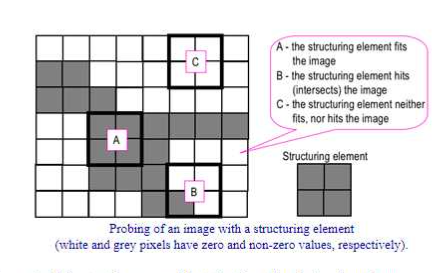

Učitavanje dataseta potrebnog za ove vežbe
- učitati images.zip

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn" -O images.zip && rm -rf /tmp/cookies.txt

--2021-03-29 17:59:07--  https://docs.google.com/uc?export=download&confirm=&id=11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn
Resolving docs.google.com (docs.google.com)... 108.177.13.138, 108.177.13.102, 108.177.13.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-a0-docs.googleusercontent.com/docs/securesc/ffsbhmchk9d6keaj6d28nrtmf3op1896/otvb2g4sacvh8f2cr5v6ndlc4hv8fq2o/1617040725000/07050430151874469418/09407418392656587965Z/11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn?e=download [following]
--2021-03-29 17:59:07--  https://doc-0c-a0-docs.googleusercontent.com/docs/securesc/ffsbhmchk9d6keaj6d28nrtmf3op1896/otvb2g4sacvh8f2cr5v6ndlc4hv8fq2o/1617040725000/07050430151874469418/09407418392656587965Z/11lHO0f2GQnyMSHhzN1yHRpJVOZmxaDFn?e=download
Resolving doc-0c-a0-docs.googleusercontent.com (doc-0c-a0-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to

Unzip dataseta

In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
 extracting: images/blackhole.png    
  inflating: images/blackhole_out.png  
  inflating: images/blob_log_out.png  
  inflating: images/blob_watershed_out.png  
 extracting: images/bo.png           
 extracting: images/bo_inv_1.png     
 extracting: images/bo_inv_2.png     
  inflating: images/card.png         
  inflating: images/card_out.png     
  inflating: images/chainlink.png    
  inflating: images/circles.png      
  inflating: images/dice.png         
  inflating: images/dice_out.png     
  inflating: images/edge_skel.png    
  inflating: images/edt.png          
  inflating: images/edt_iter_erode.png  
 extracting: images/fingerprint.png  
  inflating: images/fingerprint_out.png  
 extracting: images/frame1.png       
 extracting: images/frame2.png       
  inflating: images/giraffe.png      
  inflating: images/grad_3d.png      
  inflating: images/hmt.png          
  inflating: images/hm_out_1.png     
  inflating: images/hm_out_2.

### Morphological Pattern Matching // Podudaranje morfološkog obrasca

Za podudaranje morfološkog obrasca koristićemo *hit-or-miss-transform*, kako bismo pronašli obrasce iz binarne fotografije.

*Hit-or-miss* transformacija je morfološka operacija koja se koristi za otkrivanje datog obrasca u binarnoj fotografiji. Koristi par razdvojenih strukturnih elemenata da definiše obrazac koji se podudara i morfološki operater erozije da primeni podudaranje uzorka. *Hit-or-miss* transformacija vraća binarnu fotografiju kao izlaz u kojoj su samo oni skupovi pozicija različiti od nule, gde se prva SE podudara, a druga SE u potpunosti propušta prvi plan u ulaznoj binarnoj fotografiji.



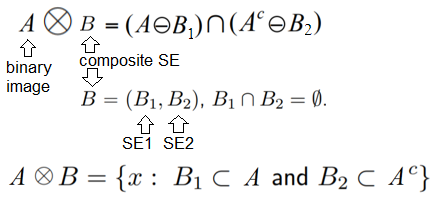


Funkcija *binary_hit_or_miss()*, iz modula *scipy.ndimage.morphology*, koristiće se za primenu morfološke operacije *hit-or-miss* na binarnu fotografiju.


Ulazna binarna fotografija, zajedno sa nekoliko razdvojenih elemenata strukturiranja, prosleđuju se funkciji. Prvi argument SE predstavlja deo SE koji mora odgovarati (*hit*) prvom planu. Drugi argument SE predstavlja deo SE koji mora u potpunosti propustiti (*miss*) prvi plan.


Funkcija *binary_hit_or_miss()* pronalazi lokacije unutar ulazne fotografije koje se podudaraju sa datim obrascem (definisanim SE).

Funkcija *np.where()* se koristi za pronalaženje koordinata podudaranja i ti podudarni pikseli će zatim biti istaknuti crvenom bojom (pomoću funkcije *gray2rgb()* iz modula skimage.color za pretvaranje 2D binarne fotografije u 3D fotografiju u boji).


(1046, 700) (34, 27) (34, 27)


<Figure size 432x288 with 0 Axes>

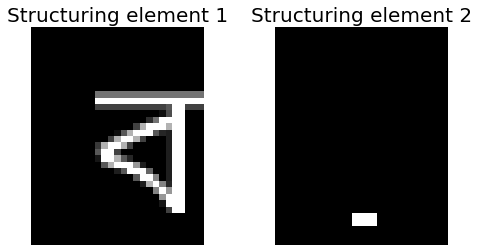

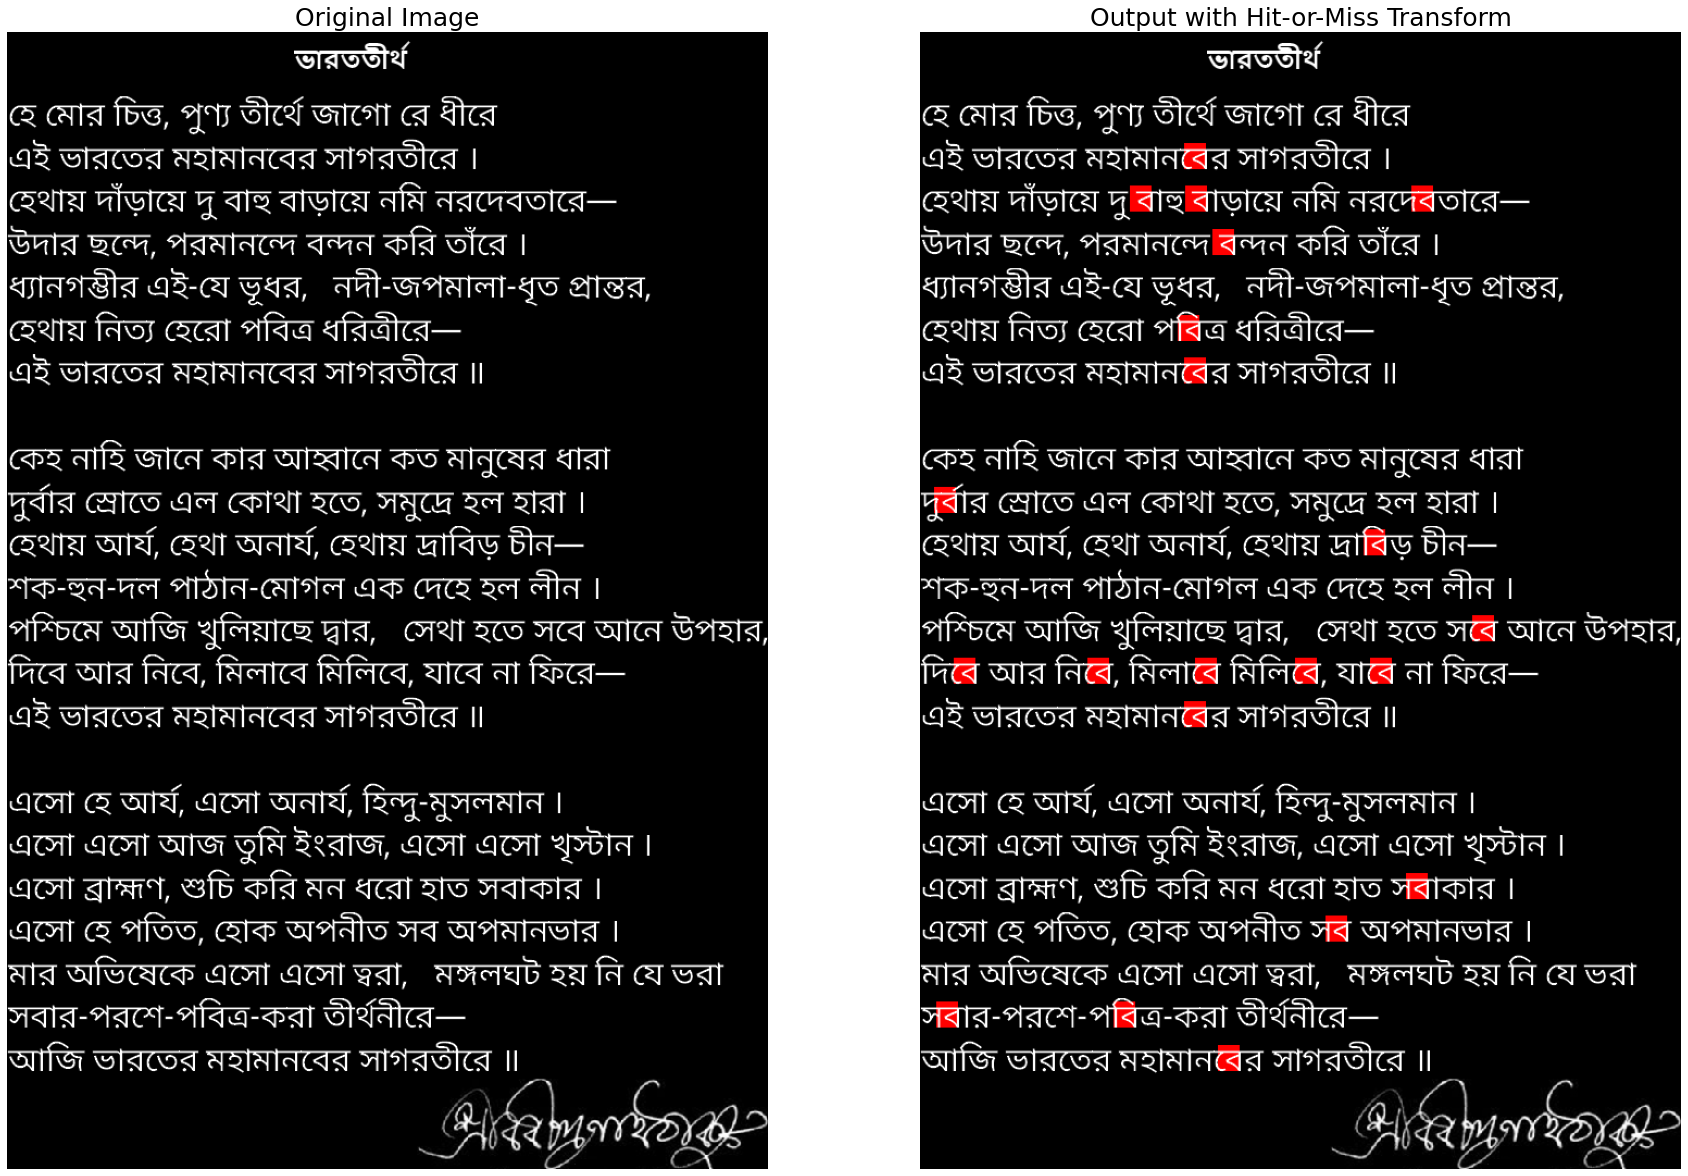

(1046, 700) (34, 27) (34, 27)


<Figure size 432x288 with 0 Axes>

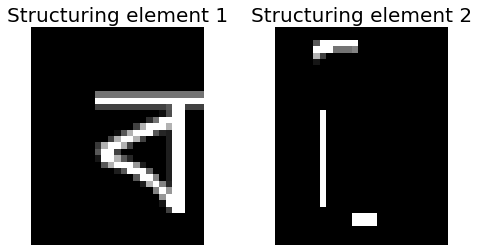

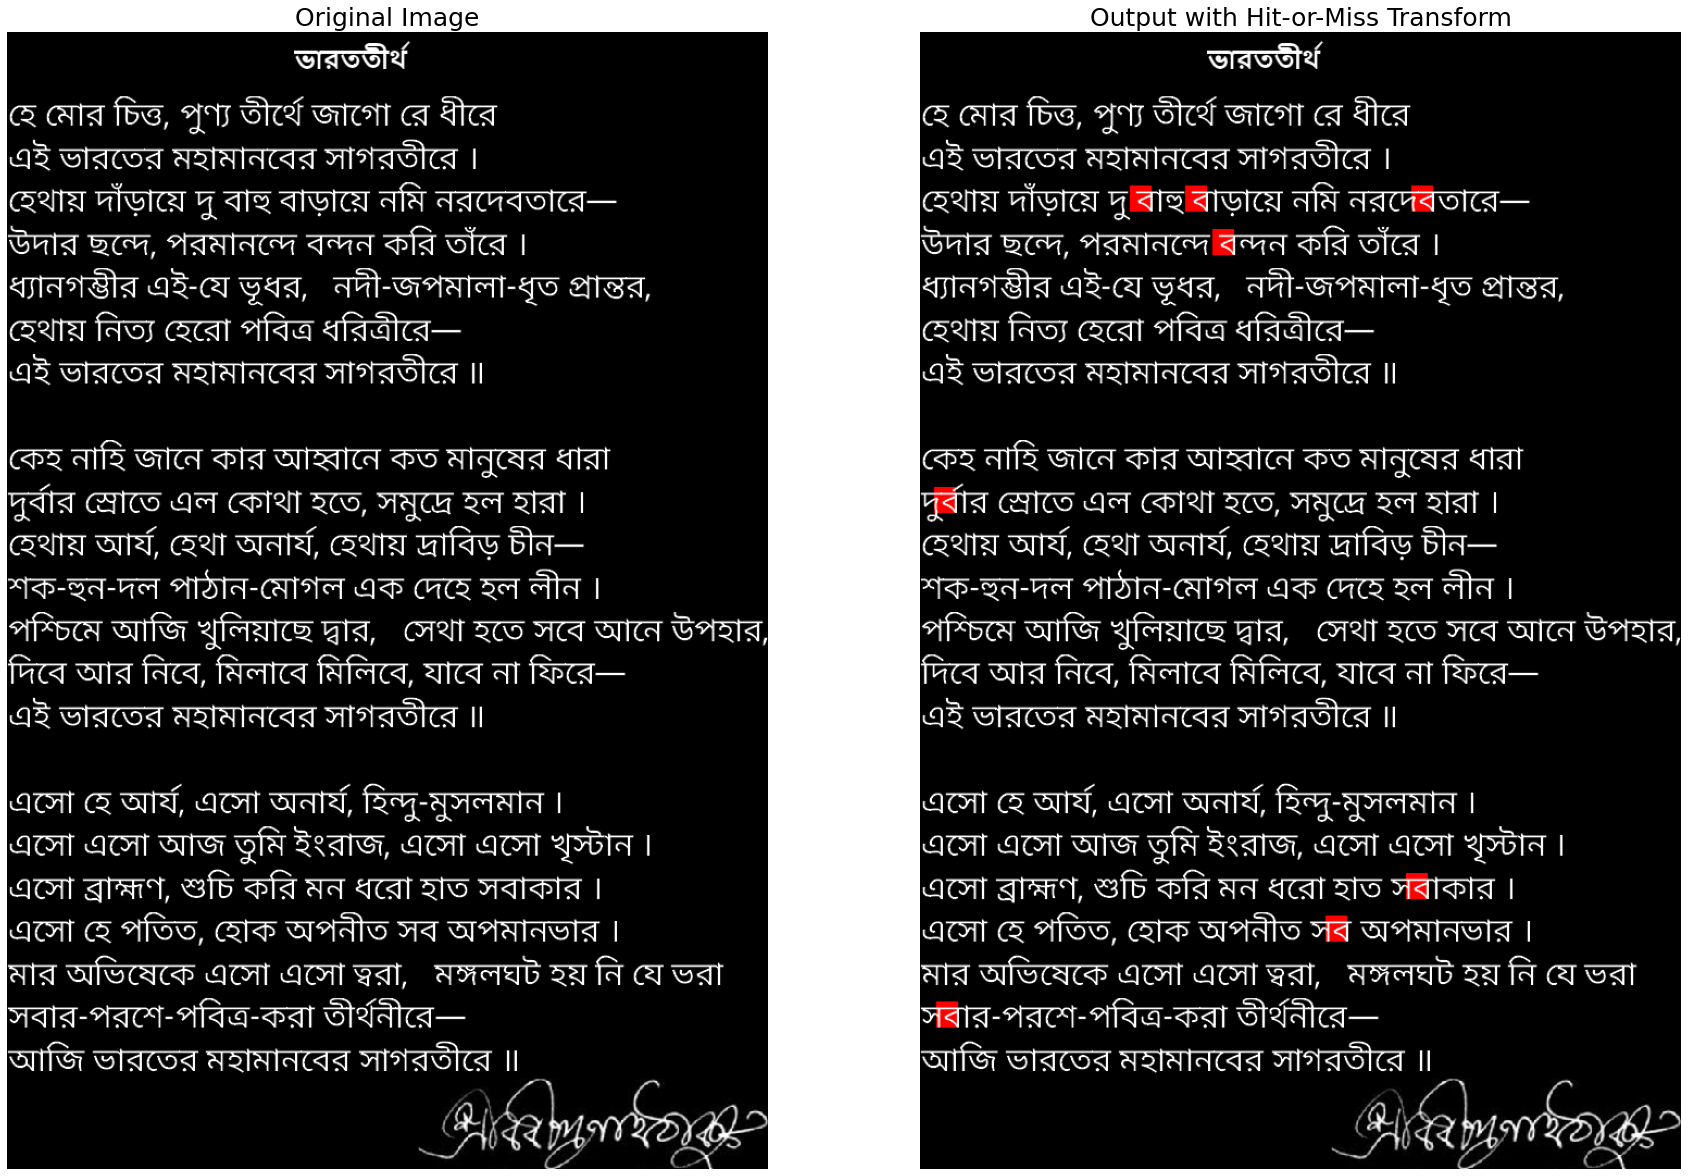

In [ ]:
import numpy as np
import matplotlib.pylab as plt
from skimage.io import imread
from skimage.color import rgb2gray, gray2rgb
from scipy import ndimage

# funkcija prihvata ulaznu fotografiju i 2 SE (1 za hit, 1 za miss)
def hit_or_miss_transform(im, s1, s2):
    im = rgb2gray(imread(im))
    m, n = im.shape
    s1 = rgb2gray(imread(s1))
    s2 = rgb2gray(imread(s2))
    print(im.shape, s1.shape, s2.shape)
    plt.gray()
    plt.figure(figsize=(8,4))
    plt.subplot(121), plt.imshow(s1), plt.axis('off'), plt.title('Structuring element 1', size=20)
    plt.subplot(122), plt.imshow(s2), plt.axis('off'), plt.title('Structuring element 2', size=20)
    plt.show()

    # povratna vrednost predstavlja Boolean NumPy ndarraym, gde su elementi koji odgovaraju položaju podudaranja postavljeni na True
    hom_transformed = ndimage.binary_hit_or_miss(im, structure1=s1, structure2=s2).astype(np.int)
    
    # označite podudaranja (piksele sa vrednošću 1) crvenim kvadratima i nacrtajte istaknutu izlaznu sliku koristeći sledeći kod:
    xs, ys = np.where(hom_transformed == 1)
    hom_transformed = gray2rgb(hom_transformed)
    w, h = 10, 12 #s1.shape
    #print(w,h,m,n)
    for i in range(len(xs)):
        x, y = (xs[i], ys[i])
        for j in range(max(0, x-h), min(m-1, x+h)):
            for k in range(max(0, y-w), min(n, y+w)):
                hom_transformed[j, k, 0] = 1.
        for j in range(max(0, x-h), min(m, x+h)):
            for k in range(max(0, y-w), min(n-1, y+w)):
                hom_transformed[j, k, 0] = 1.
    #np.max(hom_transformed)
    plt.figure(figsize=(30,60))
    #plt.imshow(hom_transformed.astype(np.float))
    plt.subplot(121), plt.imshow(im), plt.axis('off'), plt.title('Original Image', size=25)
    plt.subplot(122), plt.imshow(np.clip(gray2rgb(im) + hom_transformed.astype(np.float), 0, 1)), plt.axis('off'), 
    plt.title('Output with Hit-or-Miss Transform', size=25)
    plt.show()

# Prvi SE podudara se sa obrascima ব i র, ali drugi SE odbacuje obrazac র
hit_or_miss_transform('images/poem.png', 'images/bo.png', 'images/bo_inv_1.png') 
# podudaranje obrazaca kao što je ব, osim onih sa znakovima: িব i ব
hit_or_miss_transform('images/poem.png', 'images/bo.png', 'images/bo_inv_2.png') 

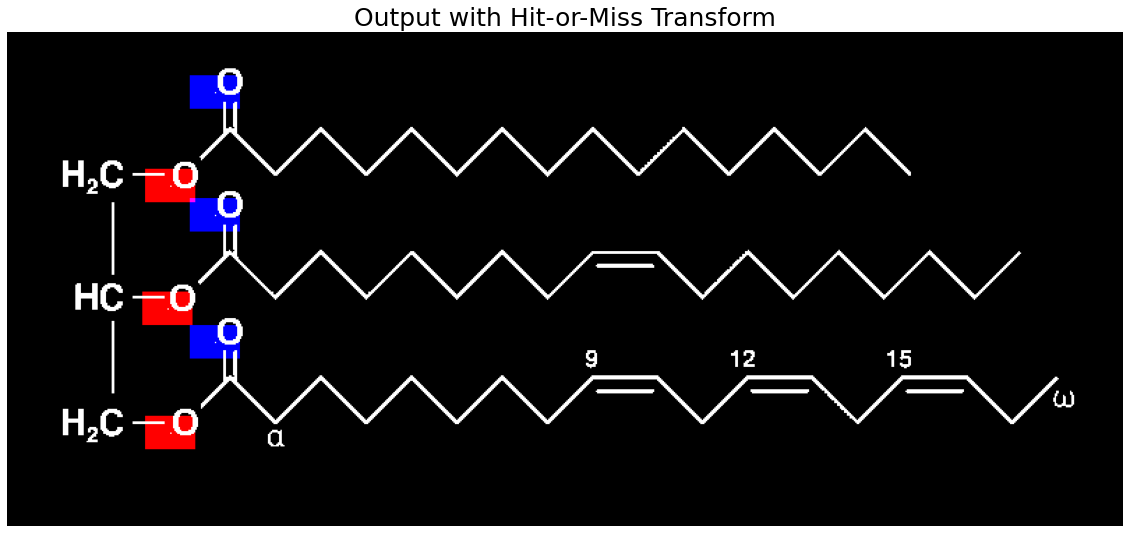

In [ ]:
# Primena ekstrakcije morfološkog uzorka na organsku hemiju: pronađite vezu -O- i =O iz sledeće strukture molekula triglicerida i istaknite ih

def hit_or_miss_transform2(im, s1, s2, ch):
    m, n = im.shape
    hom_transformed = ndimage.binary_hit_or_miss(im, structure1=s1, structure2=s2).astype(np.uint8)
    xs, ys = np.where(hom_transformed == 1)
    hom_transformed = gray2rgb(hom_transformed)
    w, h = 18, 12 #s1.shape
    for i in range(len(xs)):
        x, y = (xs[i], ys[i])
        for j in range(max(0, x-h), min(m-1, x+h)):
            for k in range(max(0, y-w), min(n, y+w)):
                hom_transformed[j, k, ch] = 1.
        for j in range(max(0, x-h), min(m, x+h)):
            for k in range(max(0, y-w), min(n-1, y+w)):
                hom_transformed[j, k, ch] = 1.
    return hom_transformed
    
im = rgb2gray(imread('images/triglyceride.png'))
s1 = rgb2gray(imread('images/tg_se1.png'))
s2 = rgb2gray(imread('images/tg_se2.png'))
s3 = rgb2gray(imread('images/tg_se3.png'))
pat1 = hit_or_miss_transform2(im, s1, s2, 0) 
pat2 = hit_or_miss_transform2(im, s1, s3, 2) 
plt.figure(figsize=(20,10))
plt.imshow(np.clip(gray2rgb(im) + pat1.astype(np.float) + pat2.astype(np.float), 0, 1)), plt.axis('off') 
plt.title('Output with Hit-or-Miss Transform', size=25)
plt.show()


### Segmentation: Morphological Watershed // Segmentacija: morfološki “sliv”

Segmentacija fotografije je proces podele digitalne fotografije na više segmenata (skupova piksela). Cilj segmentacije je pojednostavljivanje i/ili promena prikaza fotografije u nešto što je značajnije i lakše za analizu. Segmentacija se obično koristi za lociranje objekata i granica (linija, ivica, itd.) na fotografijama. Tačnije, segmentacija fotografije je postupak dodeljivanja oznake svakom pikselu na fotografiji tako da pikseli sa istom oznakom dele određene karakteristike.

Tip segmentacije na koji ćemo se fokusirati je metoda segmentacije zasnovana na regionu (*Region-based*) za binarnu fotografiju pomoću morfološkog algoritma sliva (*morphological watershed algorithm*). 

*Grayscale* fotografiju možemo smatrati topografskom površinom. Ako ovu površinu “poplavimo” od njenih minimalnih vrednosti i sprečimo spajanje voda iz različitih izvora, fotografija se zatim deli na dva različita skupa, naime slivne bazene (segmente) i slivove. Da bi se sprečila prekomerna segmentacija, koristi se unapred definisani skup markera i “poplava” površine započinje od ovih markera. 

Koraci koji su uključeni u segmentaciju fotografije:

*   Pronađite markere i kriterijum segmentacije (funkcija koja će se koristiti za podelu regiona; to je često kontrast/gradijent).
*   Pokrenite algoritam sliva pod kontrolom markera sa ova dva elementa.







23 22


<Figure size 432x288 with 0 Axes>

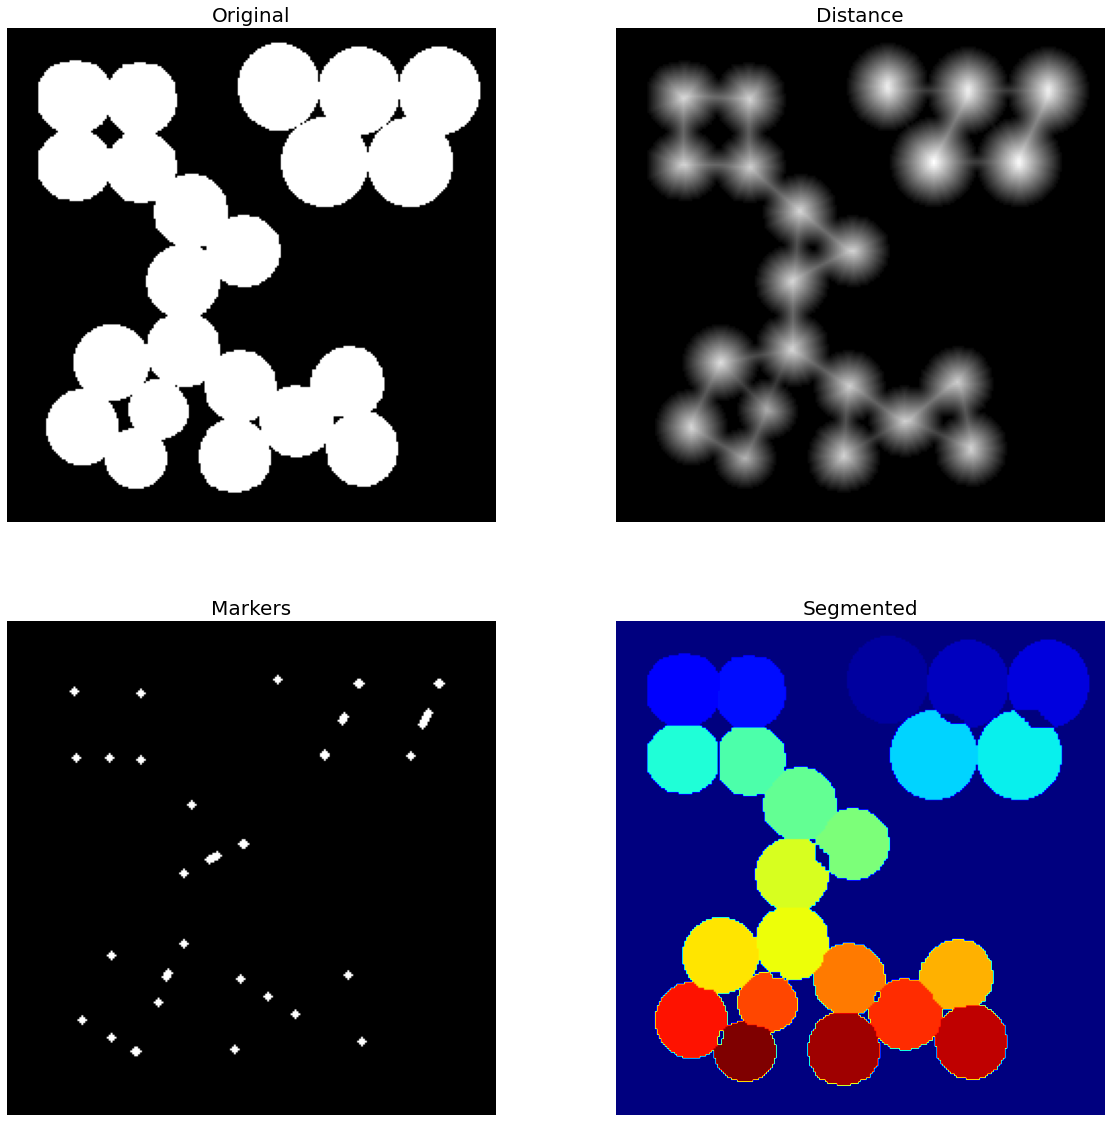

In [ ]:
from scipy import ndimage as ndi
from skimage.morphology import watershed, disk, binary_dilation, remove_small_objects
from skimage.filters import rank, threshold_otsu
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.util import img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt

# Prvo učitajte sliku ulaznih binarnih krugova i pretvorite je u sive nijanse unsigned integer tipa
image = img_as_ubyte(rgb2gray(imread('images/circles.png'))) #img_as_ubyte(data.camera())

# Izračunajte Euklidsku transformaciju daljine i pronađite vrhove u njoj, označavajući ih naknadno da bi ih koristili kao markere za watershed algoritam 
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = ndi.label(local_maxi)[0]

# Pokrenite algoritam watershed sa kreiranim markerom da biste dobili izlazne oznake segmentacije 
# Uklonite male objekte da biste se oslobodili šuma
labels = watershed(-distance, markers, mask=image)
labels = remove_small_objects(labels, min_size=100)

# Izračunajte broj segmentiranih objekata (labela) u izlazu i broj jedinstvenih klasa (labela):
props = regionprops(labels)
print(len(np.unique(labels)), len(props))

plt.gray()
plt.figure(figsize=(20,20))
plt.subplot(221), plt.imshow(image), plt.axis('off'), plt.title('Original', size=20)
plt.subplot(222), plt.imshow(distance), plt.axis('off'), plt.title('Distance', size=20)
plt.subplot(223), plt.imshow(binary_dilation(markers, disk(2))), plt.axis('off'), plt.title('Markers', size=20)
plt.subplot(224), plt.imshow(labels, cmap='jet'), plt.axis('off'), plt.title('Segmented', size=20)
plt.show()

111 110


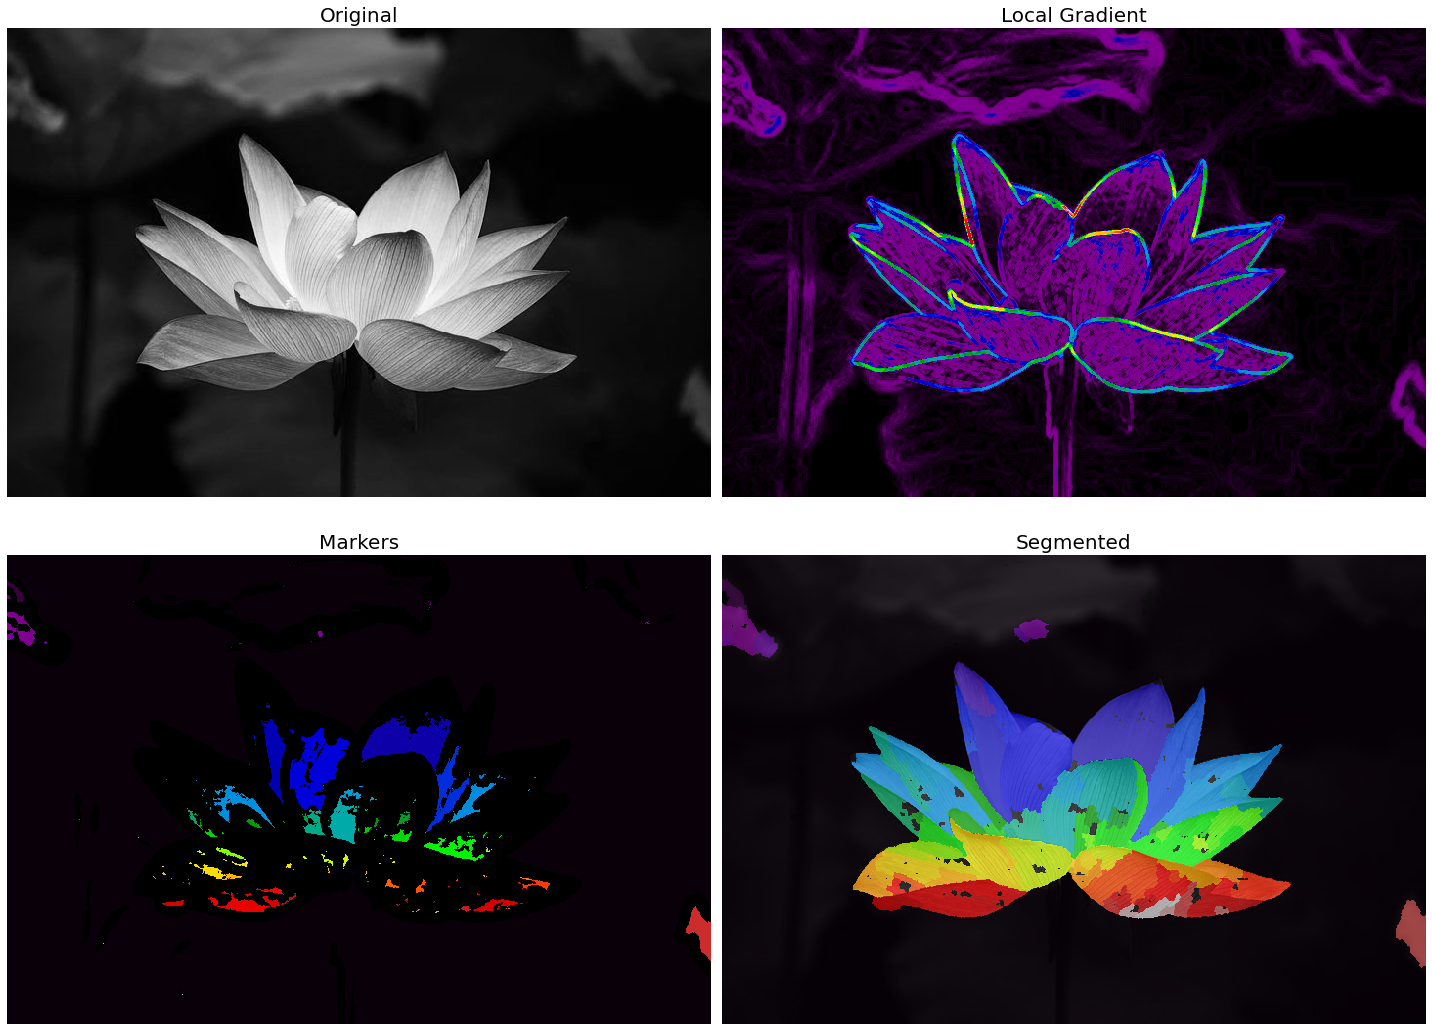

In [ ]:
from scipy import ndimage as ndi
from skimage.morphology import watershed, disk, binary_dilation, remove_small_objects
from skimage.filters import rank, threshold_otsu
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.util import img_as_ubyte
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt


image = img_as_ubyte(rgb2gray(imread('images/lotus.png')))

# Oštetite sliku srednjim filterom za početak
# Kreiranje markera pretragom kontinuirane regije, kako bi se dobila fotografije veće glatkoće (niska vrednost gradijenta i disk SE radijusa 5)
denoised = rank.median(image, disk(2))
markers = rank.gradient(denoised, disk(5)) < 20
markers = ndi.label(markers)[0]

# Lokalni gradijent (disk(2) se koristi za održavanje tankih ivica)
gradient = rank.gradient(denoised, disk(2))

# Pokretanje watershed algoritma sa gradijentom i markerom kao ulazom (koristite lokalni gradijent sa SE kao disk malog poluprečnika 2, da ivice budu tanke)
labels = watershed(gradient, markers)
labels = remove_small_objects(labels, min_size=100)
props = regionprops(labels)
print(len(np.unique(labels)), len(props))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original", size=20)

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[1].set_title("Local Gradient", size=20)

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title("Markers", size=20)

ax[3].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7)
ax[3].set_title("Segmented", size=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

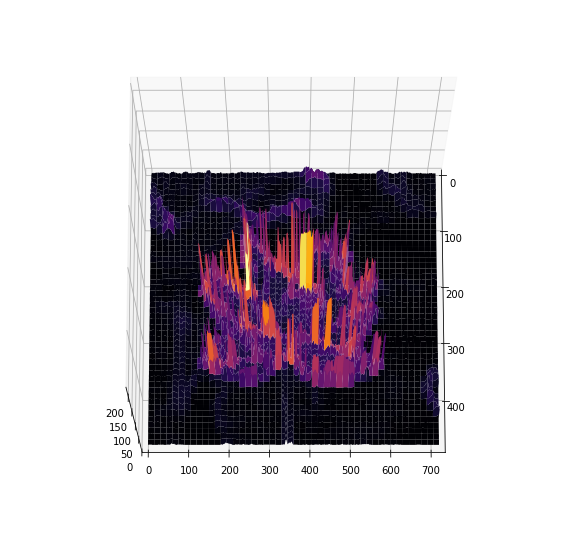

In [ ]:
# Prikaz gradijentne fotografije u 3D

#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

# Preuzimanje informacija u vezi sa oblikom fotografije 
im_shape = np.shape(gradient)
x = np.arange(0, im_shape[0], 1)
y = np.arange(0, im_shape[1], 1)

# Pravljenje mreže 
x, y = np.meshgrid(x, y)

# Pravljenje 3D plot-a
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x, y, np.transpose(gradient), cmap='inferno')
plt.xlim([0, im_shape[0]])
plt.ylim([0, im_shape[1]])

# Rotacija i nagib plot-a tako da vrhovi i doline budu očigledni
ax.view_init(75, 360)

### Blob Detection with Morphological Watershed // Detekcija objekata pomoću morfološkog "sliva"


*Blob* je u neku ruku bilo šta što se smatra velikim objektom ili bilo čim svetlim na tamnoj pozadini. Na fotografijama ga možemo generalizovati kao grupu vrednosti piksela koja čini donekle koloniju ili veliki objekat koji se razlikuje od njegove pozadine.

Funkcija *watershed()*, iz modula skimage.morphology, koristi se za pronalaženje slivova na ulaznoj fotografiji, gde je “poplava” započela od datih markera. Ova funkcija prihvata fotografiju i markere (opcionalno) kao ulazne argumente. Funkcija *watershed()* prihvata *ndarray* marker sa označenim lokacijama slivova (vrednosti piksela se koriste za dodeljivanje piksela u matrici oznake) kao drugi argument (0 znači da nije marker). 

Funkcija *distance_transform_edt()*, iz modula *scipy.ndimage.morphology*, koristi se za izračunavanje tačne Euklidove transformacije date sledećom jednačinom:

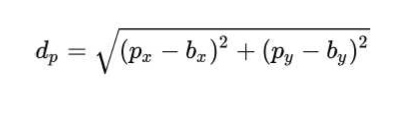

Ovde je *b* najbliži pozadinski piksel ulaznom pikselu, *p* (koji ima najmanju euklidsku udaljenost); vraćena je udaljenost, *dp*, između *p* i *b*.

Funkcija *label()*, iz modula *ski.ndimage*, koristi se za obeležavanje karakteristika u markerima, dobijenim vršenjem lokalnih maksimalnih vrednosti iz Euklidske transformacije daljine ili pragom gradientne fotografije. Ova funkcija dodeljuje jedinstvenu oznaku svakoj od jedinstvenih karakteristika na ulaznoj fotografiji. 

Funkcija *regionprops()*, iz modula *skimage.measure*, koristi se za dobijanje liste svojstava regiona, gde svaka stavka opisuje jedan označeni region.


44


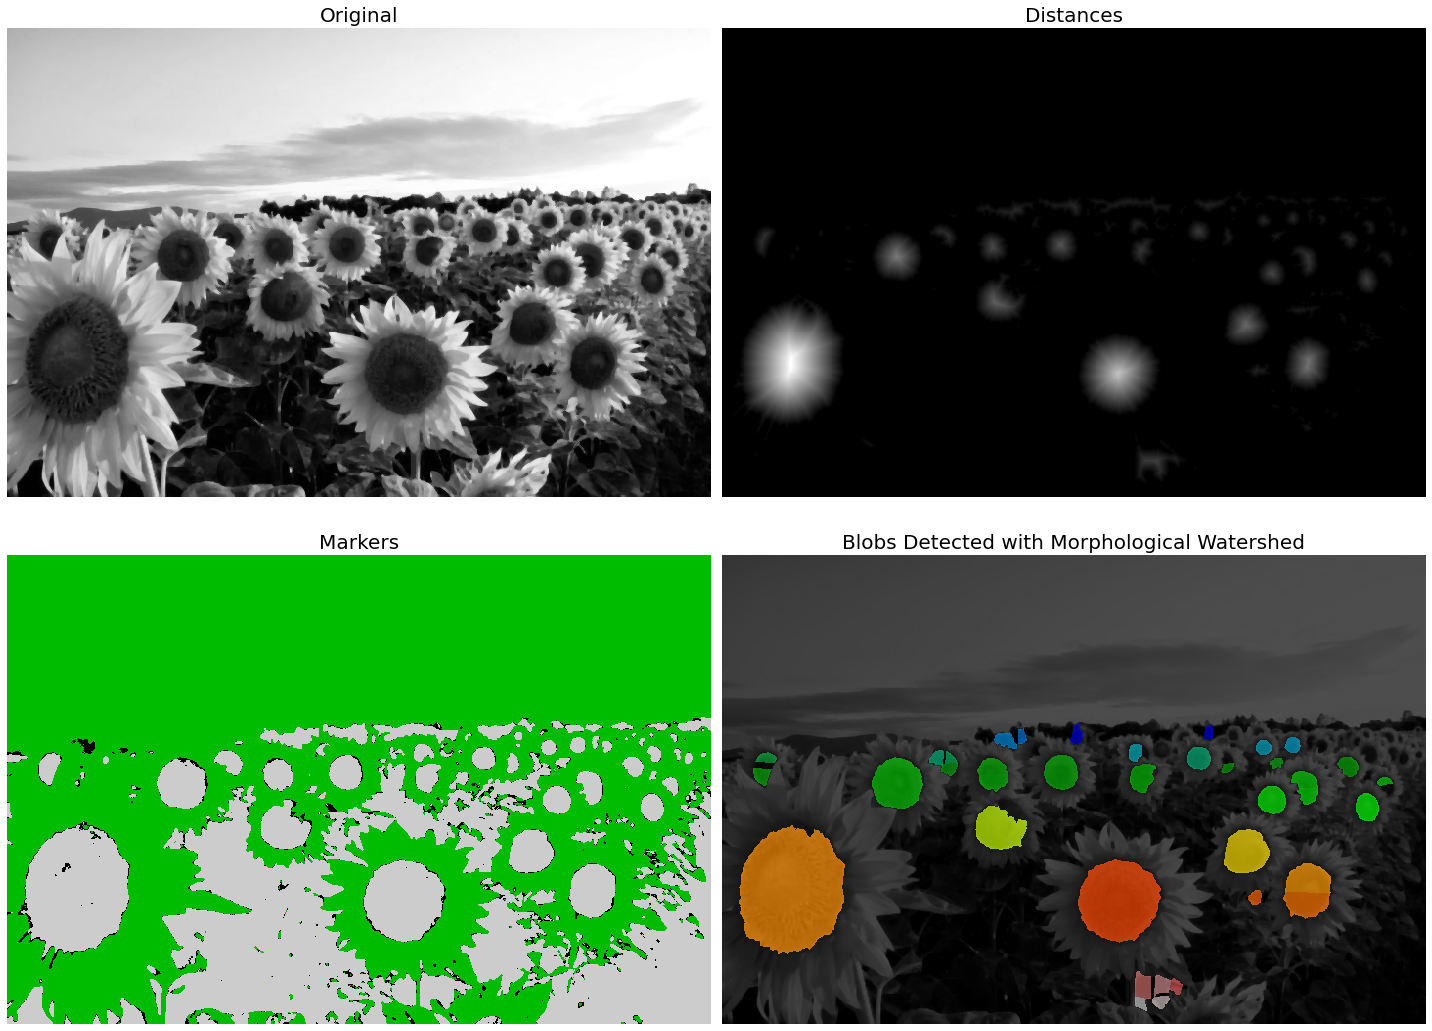

In [ ]:
from skimage.morphology import watershed, binary_erosion, remove_small_objects, square 
from scipy.ndimage import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

# Funkcija za otkrivanje objekata
def segment_with_watershed(im, cell_thresh, bg_thresh):
    
    if np.max(im) != 1.0:
        im = (im - im.min()) / (im.max() - im.min())
    
    im_mask = im < cell_thresh
    
    # Generišite "slivne bazene"
    basins = np.zeros_like(im)
    basins[im < cell_thresh] = 2
    basins[im > bg_thresh] = 1

    # Izvršite sliv "poplavom"
    flood_seg = watershed(im , basins)
    flood_seg = flood_seg > 1.0
    
    # Erodirajte granice
    selem = square(3)
    flood_erode = binary_erosion(flood_seg, selem=selem)
    flood_seg = clear_border(flood_seg, buffer_size=10)
    
    # Izračunajte transformaciju daljine
    distances = distance_transform_edt(flood_seg)
     
    # Pronađite lokalne maksimume u matrici rastojanja
    local_max = peak_local_max(
        distances, indices=False, footprint=None, labels=flood_seg,
        min_distance=1)
    max_lab = label(local_max)

    # Izvršiti topološki sliv
    final_seg = watershed(-distances, max_lab, mask=flood_seg)

    # Uklonite sve zalutale male objekte
    final_seg = remove_small_objects(final_seg, min_size=100)

    # Izdvojite svojstva regiona i odredite broj ćelija
    props = regionprops(final_seg)
    num_cells = len(props)

    return final_seg, distances, basins, num_cells  

# Učitajte ulaznu fotografiju, pretvorite je u grayscale, označite je i pronađite objekte
image = img_as_ubyte(rgb2gray(imread('images/sunflowers.png')))
image = rank.median(image, disk(2))

labels, distances, markers, nseg = segment_with_watershed(image, 0.25, 0.28)
print(nseg)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title("Original", size=20)

ax[1].imshow(distances, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title("Distances", size=20)

im = ax[2].imshow(markers, cmap=plt.cm.nipy_spectral, interpolation='nearest')
#plt.colorbar(im, ax=ax[2])
ax[2].set_title("Markers", size=20)

ax[3].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest', alpha=.7) 
ax[3].set_title("Blobs Detected with Morphological Watershed", size=20)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### Blob Detection with LOG scale-space // Detekcija objekata pomoću LOG scale-space

Detektuje objekte pomoću *Laplacian-ove Gaussove* metode.

/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.7/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


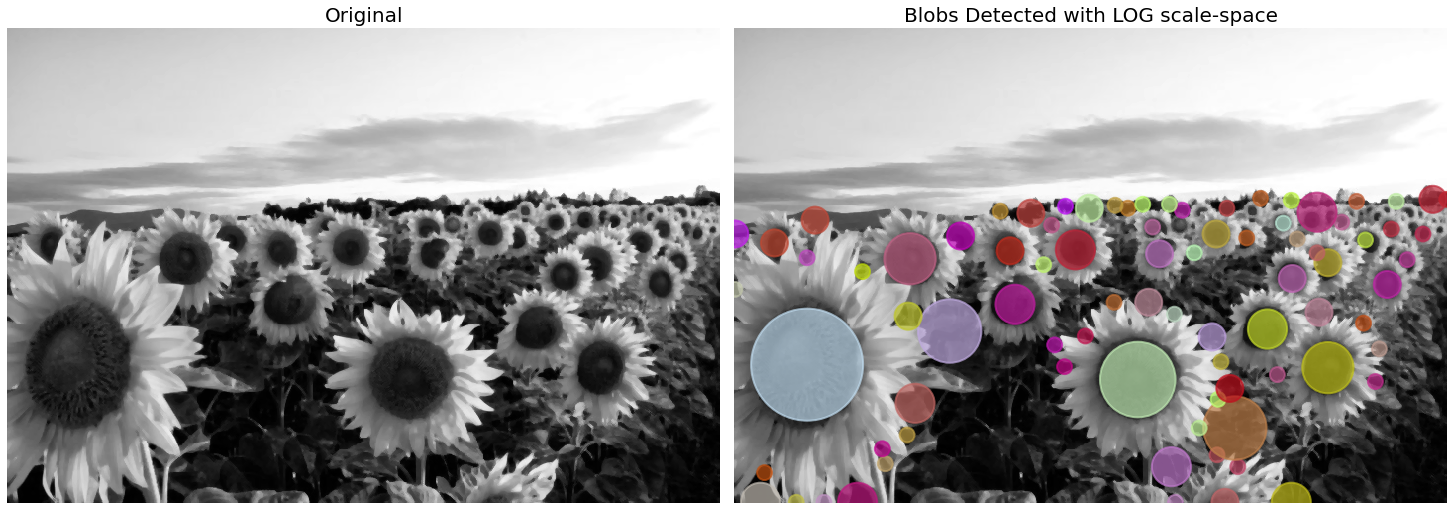

In [ ]:
from skimage.feature import blob_log
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

image = img_as_ubyte(rgb2gray(imread('images/sunflowers.png')))
image = rank.median(image, disk(2))

# Funkcija za detektovanje objekta
blobs_log = blob_log(np.invert(image), max_sigma=40, num_sigma=10, threshold=.2)

# Izračunajte radijuse u trećoj koloni
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), sharex=True, sharey=True)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.02, hspace=0.02)

axes[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
axes[0].set_title("Original", size=20)

axes[1].imshow(image, cmap=plt.cm.gray, interpolation='nearest')

# Prelistajte pronađene objekte i nacrtajte ih na izlaznoj fotografiji, ignorišući objekte malog radijusa:
for blob in blobs_log:
    y, x, r = blob
    if np.pi*r**2 > 150:
        c = plt.Circle((x, y), r, color=[0.75]+np.random.rand(2).tolist(), linewidth=2, fill=True, alpha=.7)
        axes[1].add_patch(c)
axes[1].set_title("Blobs Detected with LOG scale-space", size=20)

for a in axes:
    a.axis('off')

plt.show()

### Counting Objects // Prebrojavanje objekata

Često se objekti (*blobs*) na binarnoj fotografiji preklapaju i pre nego što ih prebrojimo.
Zbog toga moramo izvršiti neophodnu pred-obradu, poput razdvajanja i detekcije *blob*-a.


Morfološka erozija može biti vrlo korisna u ovim slučajevima. Tada se za brojanje odvojenih objekata može koristiti pronalaženje kontura. Može se koristiti i morfološka segmentacija sliva za odvojanje objekata i nakon toga ih prebrojati.


- Funkcija *morphologyEx()*, iz modula *opencv-python*, koristi se za primenu morfoloških operacija na fotografiji. Funkcija prihvata izvornu fotografiju (odnosno binarnu fotografiju) i morfološku operaciju (kao što su *cv2.MORPH_CLOSE* i *cv2.MORPH_OPEN*) i SE kernel (na primer, np.ones ((4,4), np.uint8 ) za jezgro kvadratnog oblika 4x4) za morfološku operaciju.


- Funkcije *cv2.findContours()* i *cv2.drawContours()* koriste se za pronalaženje i crtanje kontura. Svaka kontura na izlaznoj fotografiji nacrtana je slučajnim konturama u boji, a zatim prikazana jedna po jedna prevlačenjem preko pronađenih kontura.


- *(np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))* se koristi za generisanje slučajnih BGR korena. 


- Funkcija *cv2.contourArea()* koristi se za odbacivanje malih predmeta čija je površina manja ili jednaka 5.

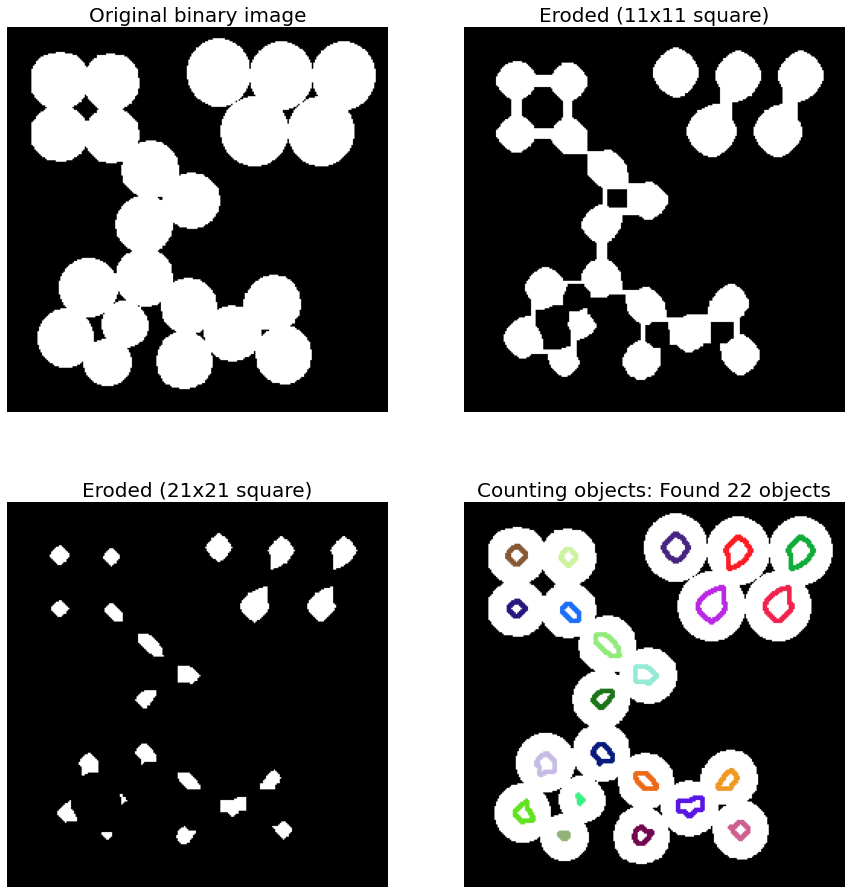

In [ ]:
import cv2
import numpy as np
import matplotlib.pylab as plt

# Učitajte grayscale fotografiju i pretvorite je u binarnu fotografiju koristeći threshold algoritam
image = cv2.imread('images/circles.png', 0)
image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)[1]

# Napravite SE (kernel) za binarnu eroziju (sa drugom veličinom kernela) i erodirajte fotografiju
kernel = np.ones((21,21),np.uint8)
eroded = cv2.morphologyEx(image, cv2.MORPH_ERODE, kernel) 
kernel = np.ones((11,11),np.uint8)
eroded1 = cv2.morphologyEx(image, cv2.MORPH_ERODE, kernel) 

# Pronađite konture erodirane fotografije
cnts, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iscrtajte konture na ulaznoj fotografiji, koristeći različite boje
output = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
count = 0
for c in cnts:
    cv2.drawContours(output, [c], -1, (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)), 2)   
    count += 1
    
text = "Found {} objects".format(count)
plt.figure(figsize=(15,16))
plt.gray()
plt.subplot(221), plt.imshow(image), plt.axis('off'), plt.title('Original binary image', size=20)
plt.subplot(222), plt.imshow(eroded1), plt.axis('off'), plt.title('Eroded (11x11 square)', size=20)
plt.subplot(223), plt.imshow(eroded), plt.axis('off'), plt.title('Eroded (21x21 square)', size=20)
plt.subplot(224), plt.imshow(output), plt.axis('off'), plt.title('Counting objects: ' + text, size=20)
plt.show()

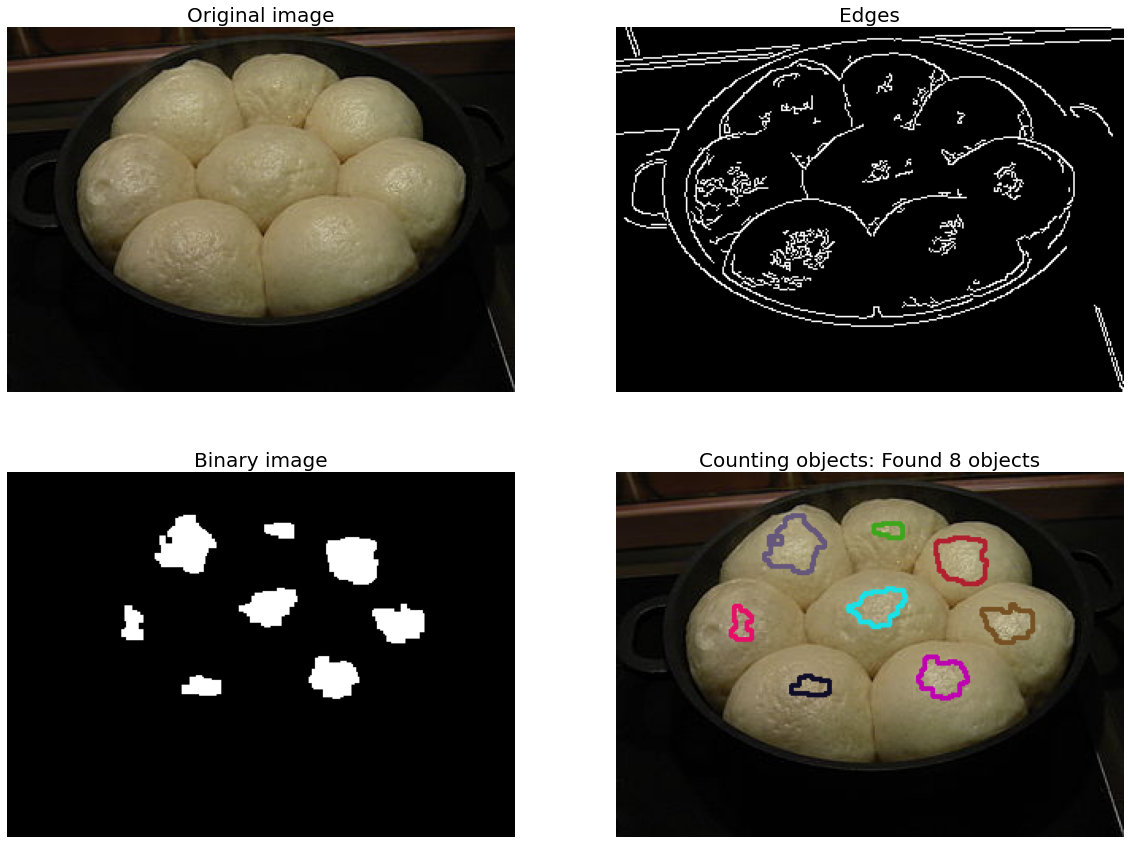

In [ ]:
import cv2

image = cv2.imread('images/rasagolla.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray) #255 - gray
#gray = cv2.equalizeHist(gray)

# Koristite Canny detektor ivica da biste pronašli ivice na fotografiji, pa zatim graničite ivičnu fotografiju 
edged = cv2.Canny(gray, 50, 150)
thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)[1]
# Koristeći SE (4x4), primenite binarno zatvaranje praćeno binarnim otvaranjem na graničnoj fotografiji (da odvojite objekte)
kernel = np.ones((4,4),np.uint8)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel) #Close
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)  #Open

#ret, thres = cv2.threshold(edged,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Pronađite konture (odnosno obrise) objekata u prvom planu na fotografiji (dobijenoj iz prethodnog koda)
cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

output = image.copy()
count = 0
# Prelazite preko pronađenih kontura, da biste ih nacrtali na izlaznoj fotografiji (ponovo koristeći različite boje), ignorišući male objekte
for c in cnts:
    # Nacrtajte svaku konturu na izlaznoj fotografiji sa slučajno odabranom bojom od 2 piksela, a zatim prikažite izlazne konture jednu po jednu
    #print(cv2.contourArea(c))
    if cv2.contourArea(c) > 5: # ignore small objects
        cv2.drawContours(output, [c], -1, (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255)), 2)   
        count += 1
    
text = "Found {} objects".format(count)
plt.figure(figsize=(20,15))
plt.subplot(221), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Original image', size=20)
plt.subplot(222), plt.imshow(edged, cmap='gray'), plt.axis('off'), plt.title('Edges', size=20)
plt.subplot(223), plt.imshow(thresh, cmap='gray'), plt.axis('off'), plt.title('Binary image', size=20)
plt.subplot(224), plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Counting objects: ' + text, size=20)
plt.show()

### Detect and Separate different types of objects // Detekcija i razdvajanje različitih vrsta objekata


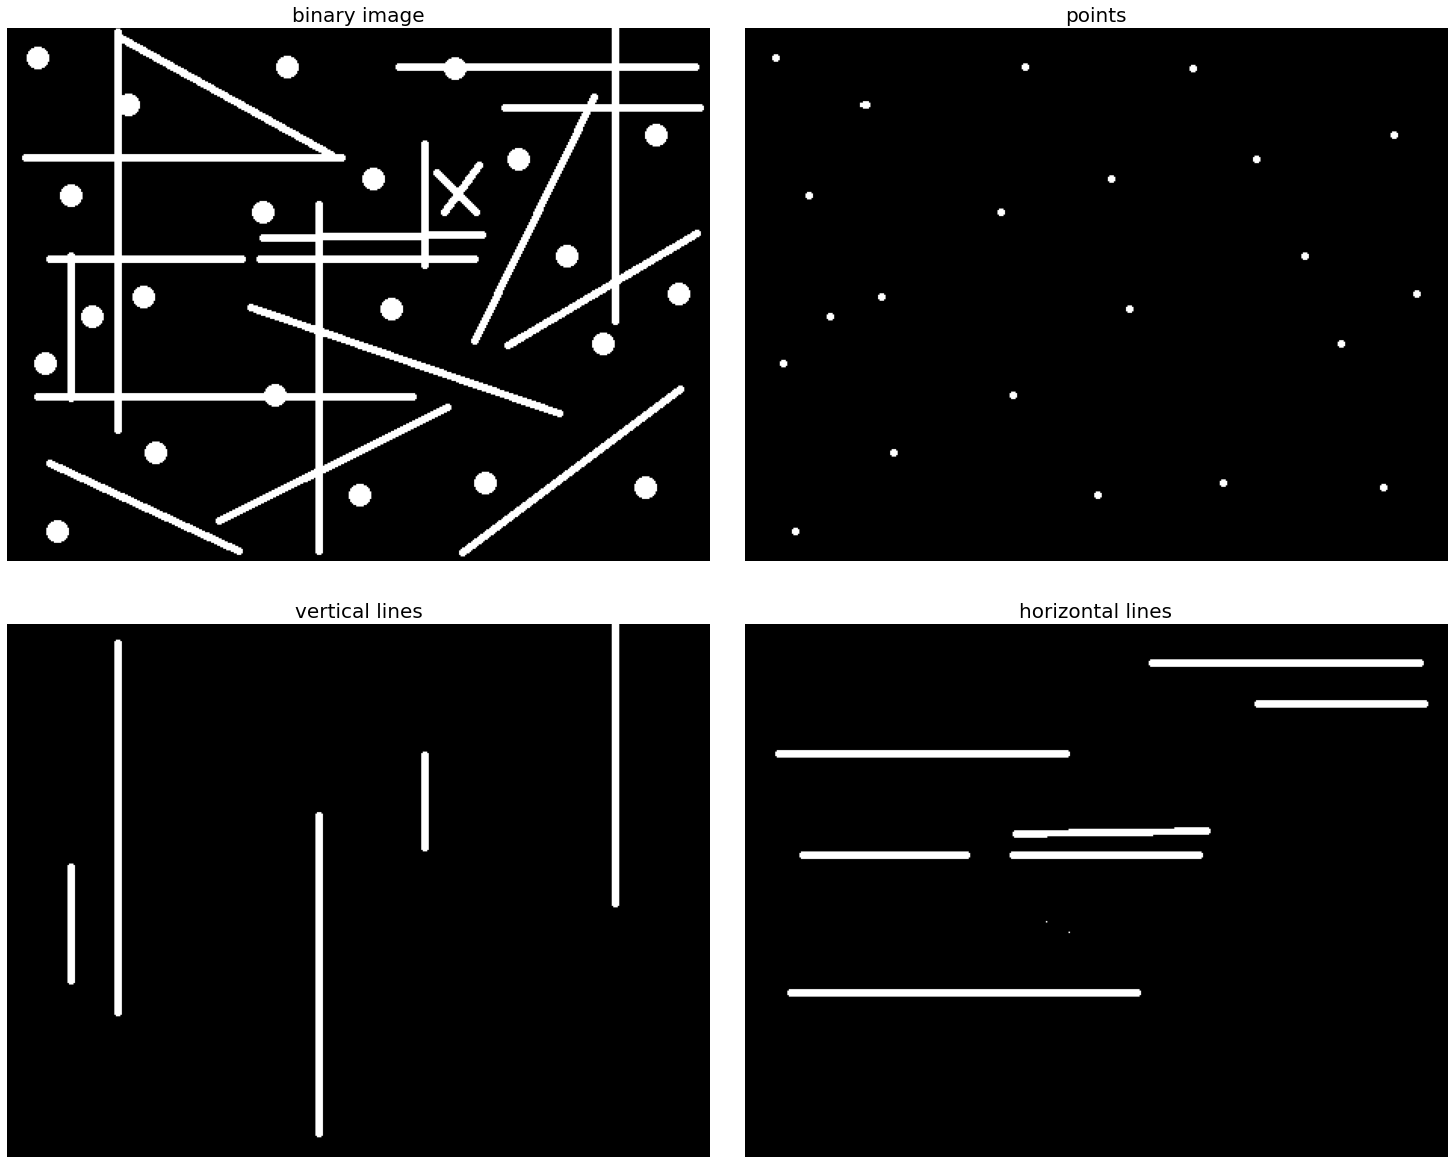

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import disk, rectangle

im = rgb2gray(imread('images/points_with_lines.png'))
th = threshold_otsu(im)
im = (im >= th).astype(np.uint8)
eroded1 = binary_erosion(im, disk(5))
eroded2 = binary_erosion(im, rectangle(20, 1))
eroded3 = binary_erosion(im, rectangle(1, 20))

plt.figure(figsize=(20,17))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('binary image', size=20)
plt.subplot(222), plt.imshow(eroded1), plt.axis('off'), plt.title('points', size=20)
plt.subplot(223), plt.imshow(eroded2), plt.axis('off'), plt.title('vertical lines', size=20)
plt.subplot(224), plt.imshow(eroded3), plt.axis('off'), plt.title('horizontal lines', size=20)

plt.show()

## Dodatni primeri

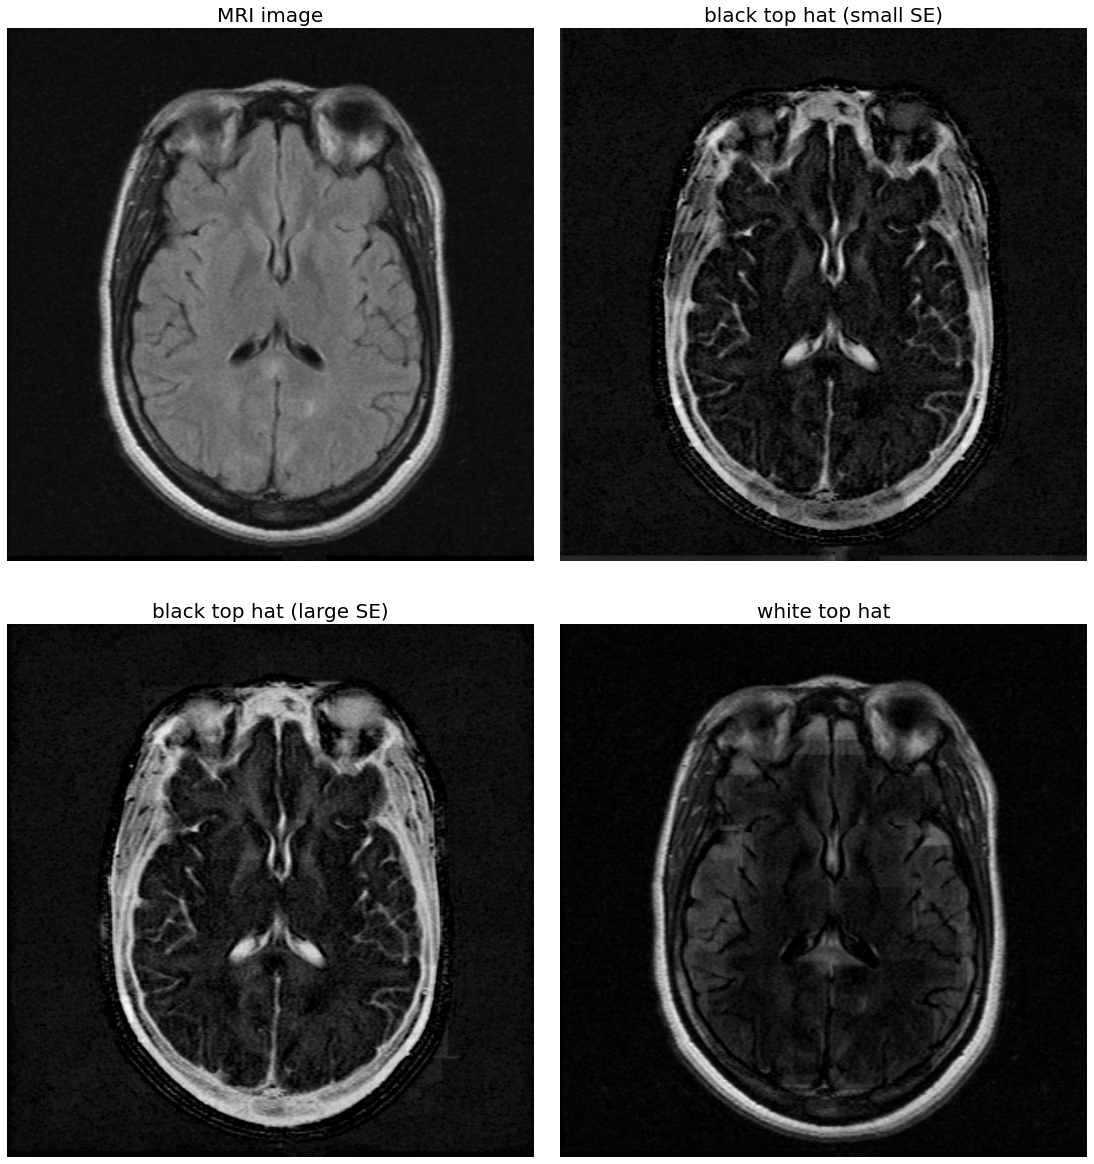

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import disk, square, black_tophat, white_tophat

im = rgb2gray(imread('images/mri.png'))
eroded1 = black_tophat(im, disk(20))
eroded2 = black_tophat(im, square(50))
eroded3 = white_tophat(im, square(50))

plt.figure(figsize=(15,17))
plt.gray()
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0.05)
plt.subplot(221), plt.imshow(im), plt.axis('off'), plt.title('MRI image', size=20)
plt.subplot(222), plt.imshow(eroded1), plt.axis('off'), plt.title('black top hat (small SE)', size=20)
plt.subplot(223), plt.imshow(eroded2), plt.axis('off'), plt.title('black top hat (large SE)', size=20)
plt.subplot(224), plt.imshow(eroded3), plt.axis('off'), plt.title('white top hat', size=20)
plt.show()

## Korisni linkovi

* [Morphological](https://web.stanford.edu/class/ee368/Handouts/Lectures/2019_Winter/7-Morphological.pdf)
* [scipy.ndimage.morphology.binary_hit_or_miss](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_hit_or_miss.html)
* [skimage.morphology.watershed](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed)



## Reference


1.   [Python Image Processing Cookbook](https://www.amazon.com/Python-Image-Processing-Cookbook-processing-ebook/dp/B084ZN7Y5F), Sandipan Dey
